## Область подключения модулей и написания функций

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#Импорт библиотек
import warnings
warnings.simplefilter('ignore')

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from collections import Counter
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# Функция без гистограммы
def col_info(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))

# Функция с гистограммой
def col_info_hist(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))
    ys.hist()
    
    
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='overall', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

## Подключение датасетов

In [6]:
#Jupyter
DIR = 'input/'

#Kaggle
#DIR = '/kaggle/input/recommendationsv4/'

import os
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/meta_Grocery_and_Gourmet_Food.json
input/sample_submission.csv
input/test.csv
input/train.csv


In [7]:
train = pd.read_csv(DIR+'train.csv')
test = pd.read_csv(DIR+'test.csv')
submission = pd.read_csv(DIR+'sample_submission.csv')

## Создание датасета из .json файла

Сконвертируем и посмотрим, какие данные находятся в json файле.

In [8]:
# Постройчно прочитаем json с метаданными и положим результат в датасет "meta"
with open(DIR+'meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)

In [9]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


Судя по всему, перед нами датасет с разными типами продуктов - их стоимостью, категориями, описанием, и.т.д.

## Оценка наборов данных

In [10]:
train.sample(5)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
511409,5.0,True,"09 9, 2017",B0085IFB62,Oregon Raven,"This corn pops well, and tastes good. I think...",Nice Popcorn,1504915200,NaN,NaN,NaN,36169,19165,1.0
748739,3.0,True,"03 21, 2016",B008YYA0NG,Amazon Customer,The flavor was great. The only reason for 3 s...,Taste great! Beware of oil spills.,1458518400,NaN,{'Size:': ' 10 pouches'},NaN,81038,19548,0.0
122716,5.0,True,"12 29, 2012",B001V76MFS,Shemekisa Jobe,i just got my item and i love it i will be get...,great,1356739200,NaN,"{'Size:': ' 36 Count', 'Flavor:': ' Pringles V...",NaN,3819,9795,1.0
833263,5.0,True,"03 29, 2013",B0019LPM0C,Ralph,"Such a perfect sweetener! I love sweets, but ...",I love stevia!,1364515200,NaN,{'Size:': ' 1 oz'},NaN,41918,6833,1.0
686364,5.0,True,"09 17, 2017",B013KUW2XE,joan pascale,sent to Houston Texas and got there in 3 days....,Five Stars,1505606400,NaN,{'Size:': ' Care Package 30 Count'},NaN,23021,34962,1.0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


Тренировочный представляет собой список отзывов покупателей о товаре. Приведены (по порядку):

* overall - Общая оценка. Пропуски отсутствуют.
* verified - Был ли отзыв подтвержден. Пропуски отсутствуют (проверим это потом отдельно для столбцов, чтобы быть точно уверенными).
* reviewTime - Время написания отзыва
* asin - индивидуальный номер каждого товара, судя по всему может использоваться для идентификации товара и установления связи между датасетами
* reviewerName - ...и имя пользователя, оставившего отзыв
* reviewText - Текст отзыва, который может быть использован для получения дополнительных данных
* summary - Суть отзыва
* unixReviewTime - Время написания отзыва
* vote - Количество голосов
* style - Данные, связанные с товаром
* image - Изображение продукта в виде ссылки
* userid - id пользователя
* itemid - id товара
* rating - рейтинг товара

Отметим, что полностью заполнены только первые четыре и последние три поля. Все остальные, в особенности image и style, содержат пропуски в том или ином количестве.

Посмотрим на тестовый датасет:

In [12]:
test.sample(5)

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
183613,True,"11 7, 2014",B00KSN9TME,Anna B,1415318400,NaN,NaN,NaN,50666,29237,183613
23942,True,"03 3, 2018",B01CP2ID7C,Cody Pudlish,1520035200,NaN,"{'Size:': ' 2 Ounce', 'Flavor:': ' Maple'}",NaN,118387,37136,23942
241203,True,"06 5, 2017",B00LNXOTDW,mz rose,1496620800,2,{'Size:': ' 2lb'},NaN,100688,29631,241203
139819,False,"04 26, 2017",B0011CX1SE,Anonimo,1493164800,NaN,{'Size:': ' One 8 oz Spicy'},NaN,85431,5652,139819
252137,True,"11 20, 2016",B001U7TX0K,Sherry L. Scott,1479600000,NaN,NaN,NaN,103131,9740,252137


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


Видим, что в тренировочном датасете на 4 столбца больше:

* overall - оценка по пятибальной шкале присутствует;
* reviewText - текст отзыва присутствует;
* summary - краткое содержание отзыва;
* rating - целевая переманная

отсутствует Id

Посмотрим на meta

In [14]:
meta.sample(5)

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
126708,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[More in ordinary instant coffee! This is the ...,Kopiko Instant 3 in 1 Brown Coffee - 30 Packet...,Kopiko,"17,189inGroceryGourmetFood(",NaN,Grocery,$11.80,B00ANR3Z5W,"[B008532DLS, B07BD3CK4F, B073SH9V1R, B01H7OMLV...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN
134819,"[Grocery & Gourmet Food, Candy & Chocolate, Ch...",[Suitable for vegetarians French Cocoa Dusted ...,Monty Bojangles French Cocoa Dusted Truffles W...,Monty Bojangles,"1,400,414inGroceryGourmetFood(",NaN,Grocery,NaN,B00BHFDIWY,NaN,NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
205468,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",NaN,Tres Hermanas Nacho Sliced Jalapenos 12 Oz (Pa...,Tres Hermanas,"610,262inGroceryGourmetFood(",NaN,Grocery,NaN,B00LV0SXKW,NaN,NaN,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN
5101,"[Grocery & Gourmet Food, Cooking & Baking, Ext...","[This highly-concentrated, unsweetened champag...",LorAnn Oils Super-Strength Sparkling Wine Flav...,LorAnn Oils,">#435,846 in Kitchen & Dining (See Top 100 in ...","[B00F3ZCW4E, B007BIDREU, B00F8692LO, B00XRQ2N8...",Amazon Home,$4.70,B0000VLRFQ,NaN,NaN,"May 21, 2008","[This highly-concentrated, unsweetened champag...",NaN,NaN,NaN,NaN
156781,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","[English Aristocratic big leaf tea, Orange Pek...",Hyleys Tea English Aristocratic Loose Black Te...,3M,"177,568inGroceryGourmetFood(",NaN,Grocery,$9.08,B00E5CS9RU,"[B00601FGG6, B00R13FVKI]",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Package ...",NaN,NaN,NaN


In [15]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


Похоже на базу о продуктах. Синхронизация с данными по отзывам лучше всего идет через идентификатор asin. Продукты разделены по категориям, выделены основные (category, main_cat). Есть ранг в топах по различным категориям (rank), ссылки на продукты, которые просматривают и покупают вместе с ними( also_view, also_buy), ценовая категория (price), дана ссылка на страницу объекта (details).

Подготовим датасет

In [16]:
# Удалим дубликаты из тренировочного датасета
train.drop_duplicates(inplace = True)

# Объединим тренировочный датасет и данные из meta по идентификатору asin (Amazon Standard Identification Number)
df = pd.merge(train, meta, on='asin')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

Всего 30 признаков. 1 бинарный, 5 числовых и 24 категориальных.

## EDA

### Overall

Количество пропусков: 0,
count    847593.000000
mean          4.441068
std           1.065026
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64,
Распределение:
5.0    607524
4.0    111868
3.0     59795
1.0     37071
2.0     31335
Name: overall, dtype: int64,


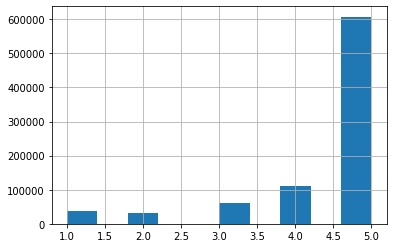

In [18]:
col_info_hist(df.overall)

Похоже на оценку по пятибальной шкале. Подавляющее большинство - пятерки. Данного признака нет в тестовой выборке, но мы можем использовать его для анализа других признаков.

In [19]:
df['overall']=df['overall'].astype('int32')

### verified

In [20]:
col_info(df.verified)

Количество пропусков: 0,
count     847593
unique         2
top         True
freq      736369
Name: verified, dtype: object,
Распределение:
True     736369
False    111224
Name: verified, dtype: int64,


Данный признак скорее всего означает, что либо комментарий, либо аккаунт пользователя подтвержден. Пропусков нет. Заменим значения на 1 и 0.

In [21]:
dic_verified = {
    True: 1,
    False: 0
}
df['verified'] = df['verified'].map(dic_verified)

Посмотрим, как влияет признак verified на среднюю оценку.

Средняя оценка при значении verified = 1:  4.479455273103566
Средняя оценка при значении verified = 0:  4.186920089189384


<AxesSubplot:>

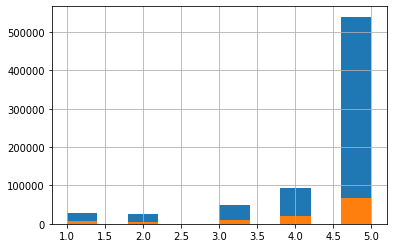

In [22]:
print('Средняя оценка при значении verified = 1: ',df[df.verified == 1].overall.mean())
df['overall'][df['verified'] == 1].hist(bins=10)
print('Средняя оценка при значении verified = 0: ',df[df.verified == 0].overall.mean())
df['overall'][df['verified'] == 0].hist(bins=10)

Видим, что средняя оценка товаров с признаком verified = 1 выше, но в целом распределение оценок похожее.

Сильной разницы между оценками заметить не удалось. Это показывает, что отзывы обоих типов составляются "честно", без накруток, которые бы показали изменение рейтинга (скажем, в неверифицированных отзывах).

### reviewTime

In [23]:
col_info(df.reviewTime)

Количество пропусков: 0,
count         847593
unique          4580
top       03 1, 2016
freq             941
Name: reviewTime, dtype: object,
Распределение:
03 1, 2016     941
07 14, 2016    873
01 20, 2016    783
06 3, 2015     783
02 20, 2016    767
              ... 
12 5, 2005       1
08 17, 2006      1
06 17, 2007      1
10 29, 2005      1
12 29, 2004      1
Name: reviewTime, Length: 4580, dtype: int64,


Дата отзыва. Эта информация есть в колонке unixReviewTime в более удобном формате. Удалим данный столбец.

In [24]:
df = df.drop(['reviewTime'], axis=1)

### reviewerName

In [25]:
col_info(df.reviewerName)

Количество пропусков: 168,
count              847425
unique             101207
top       Amazon Customer
freq                31346
Name: reviewerName, dtype: object,
Распределение:
Amazon Customer    31346
Kindle Customer     6128
Linda                729
John                 714
David                606
                   ...  
Kagey61                1
Ella Mark              1
ridere46               1
Doanld T.              1
Robert L. Kelly        1
Name: reviewerName, Length: 101207, dtype: int64,


Некоторые пользователи имеют свой айди, но при этом решили не вводить свое имя. Среди почти миллиона отзывов есть пара обширных групп - покупатели Kindle и Amazon. 
Скорее всего, отзывы оставлены через какой-либо отдельный сервис, и поэтому пользователям даны некоторые общие имена. 
Проверим, один userid у Amazon Customer, или одному имени пользователя может соответствовать несколько userid.

In [26]:
df[df.reviewerName=='Amazon Customer'].userid.value_counts()

7477      91
1330      60
24035     55
8027      53
15752     44
          ..
73871      1
115807     1
58045      1
62767      1
65437      1
Name: userid, Length: 5329, dtype: int64

В таком случае, имя пользователя нам не нужно. Удалим столбец.

In [27]:
df = df.drop(['reviewerName'], axis=1)

### reviewText

In [28]:
print('Количество пропусков: {},'.format(df.reviewText.isnull().sum()))

Количество пропусков: 278,


Посмотрим на пример отзыва

In [29]:
df.reviewText[5]

'This is one of my favorites.  It is awesome on roasted veggies or any protein. love that there is no filler ingredients or sugars!'

Данного признака нет в тестовой выборке. Удалим столбец.

In [30]:
# Удалим столбец reviewText
df = df.drop(['reviewText'], axis=1)

### summary

Данного признака нет в тестовом датасете. Удалим столбец.

In [31]:
df = df.drop(['summary'], axis=1)

### asin

ASIN - Amazon Standard Identification Number - применяется как идентификатор продуктов внутри компании Amazon.

In [32]:
col_info(df.asin)

Количество пропусков: 0,
count         847593
unique         41302
top       B00BUKL666
freq            5430
Name: asin, dtype: object,
Распределение:
B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B0001LO3FG    4252
B00R7PWK7W    2449
              ... 
B00C3YA8H6       1
B00EYAAMVE       1
B0041FWEL8       1
B0014EQHR6       1
B00BINNY3S       1
Name: asin, Length: 41302, dtype: int64,


идентификатор для модели нам не нужен, но у нас есть признаки also_buy и similar_item, для которых он может понадобиться. Пока оставим.

Видим, что всего у нас 41302 различных продукта.

В дальнейшем мы этот признак не используем т.к. пока не придумали как использовать признаки also_view и also_buy, для которых asin скорее всего понадобится. Пока что удалим.

In [33]:
df = df.drop(['asin'], axis=1)

### unixReviewTime

In [34]:
col_info(df.unixReviewTime)

Количество пропусков: 0,
count    8.475930e+05
mean     1.441914e+09
std      5.992384e+07
min      9.657792e+08
25%      1.412122e+09
50%      1.449360e+09
75%      1.485130e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64,
Распределение:
1456790400    941
1468454400    873
1433289600    783
1453248000    783
1455926400    767
             ... 
1113782400      1
1132444800      1
1167609600      1
1105142400      1
1155081600      1
Name: unixReviewTime, Length: 4580, dtype: int64,


Пропусков нет. Посмотрим, как изменялись оценки со временем.

<AxesSubplot:>

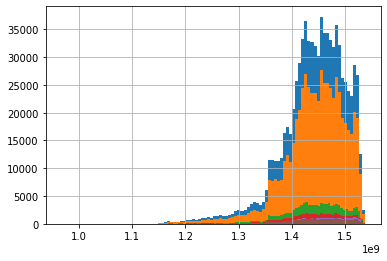

In [35]:
df.unixReviewTime.hist(bins=100)
df[df.overall == 5].unixReviewTime.hist(bins=100)
df[df.overall == 4].unixReviewTime.hist(bins=100)
df[df.overall == 3].unixReviewTime.hist(bins=100)
df[df.overall == 1].unixReviewTime.hist(bins=100)
df[df.overall == 2].unixReviewTime.hist(bins=100)

Посмотрим, на распределение отзывов по датам, приведя даты к удобному виду.

In [36]:
from datetime import datetime
tsmin = df.unixReviewTime.min()
ts25 = int(df.unixReviewTime.quantile(0.25))
ts50 = int(df.unixReviewTime.quantile(0.50))
ts75 = int(df.unixReviewTime.quantile(0.75))
tsmax = df.unixReviewTime.max()
print('Самый первый отзыв:', datetime.utcfromtimestamp(tsmin).strftime('%Y-%m-%d %H:%M:%S'))
print('25 квантиль:', datetime.utcfromtimestamp(ts25).strftime('%Y-%m-%d %H:%M:%S'))
print('50 квантиль:', datetime.utcfromtimestamp(ts50).strftime('%Y-%m-%d %H:%M:%S'))
print('75 квантиль:', datetime.utcfromtimestamp(ts75).strftime('%Y-%m-%d %H:%M:%S'))
print('Последний отзыв:', datetime.utcfromtimestamp(tsmax).strftime('%Y-%m-%d %H:%M:%S'))

Самый первый отзыв: 2000-08-09 00:00:00
25 квантиль: 2014-10-01 00:00:00
50 квантиль: 2015-12-06 00:00:00
75 квантиль: 2017-01-23 00:00:00
Последний отзыв: 2018-10-02 00:00:00


Создадим категории в зависимости от даты написания отзыва

In [37]:
# Создадим 3 категории в зависимости от даты написания
def cat_date(x):
    if x <= ts25: x = 'old'
    elif ts25 < x <= ts50: x = 'middle_old'
    elif ts50 < x <= ts75: x = 'middle_new'
    elif ts75 < x: x = 'new'
    return x      

# Заменим значения в столбце на категории
df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: cat_date(x))

### vote

In [38]:
col_info(df.vote)

Количество пропусков: 728732,
count     118861.0
unique       477.0
top            2.0
freq       30774.0
Name: vote, dtype: float64,
Распределение:
2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
122.0        1
576.0        1
120.0        1
577.0        1
155          1
Name: vote, Length: 477, dtype: int64,


In [39]:
df.vote.unique()

array([nan, 4.0, 5.0, 8.0, '7', 7.0, 3.0, 2.0, '28', '2', '4', 6.0, '3',
       '30', '14', '8', '6', '17', '5', '142', '21', '16', 9.0, 15.0,
       12.0, 18.0, 404.0, 22.0, 10.0, '22', 13.0, 136.0, '18', '12', '34',
       '69', '10', '48', '20', 11.0, 14.0, 133.0, 16.0, 36.0, 31.0, 117.0,
       17.0, 29.0, 37.0, '39', '9', '11', '27', 172.0, 251.0, '41', 52.0,
       38.0, 27.0, '15', '61', '38', 25.0, 127.0, '36', 28.0, 61.0, 24.0,
       49.0, 51.0, 19.0, 20.0, '13', 74.0, 121.0, 45.0, 33.0, 266.0, '44',
       '232', '25', 47.0, 138.0, 176.0, 75.0, 30.0, '42', 128.0, '24',
       '184', '624', 40.0, 272.0, 881.0, 53.0, 21.0, 43.0, 184.0, '35',
       35.0, 23.0, 39.0, 227.0, 42.0, 507.0, 59.0, 114.0, 87.0, 55.0,
       26.0, '19', 41.0, '82', 143.0, 73.0, 187.0, 66.0, '45', 56.0, '76',
       112.0, 57.0, '115', '75', '33', '50', 50.0, 68.0, 54.0, 63.0, '47',
       '43', 108.0, 185.0, '302', 208.0, '59', 269.0, 78.0, 103.0, '26',
       148.0, 160.0, '80', 32.0, 71.0, 130.0, 85

Скорее всего, данные признак показывает количество голосов, отданных за отзыв. Видим, что в значениях числа через запятую, с нулём и без нуля. Также видим большое количество пропусков. Скорее всего, за эти отзывы никто не проголосовал, что вполне естественно, и мы можем заменить пропуски на 0.

In [40]:
# Заменим пропуски на 0
df.vote = df.vote.fillna(0)

In [41]:
# Удалим запятые
df['vote'] = df['vote'].astype('str')
df['vote'] = df['vote'].apply(lambda x: x.replace(',', ''))
# Заменим пропуски на 0
df['vote'] = df['vote'].apply(lambda x: x.replace('nan', '0'))
df.vote = df.vote.fillna(0)
# Приведем к int32
df['vote'] = df['vote'].astype('float')
df['vote'] = df['vote'].astype('int32')
# Посмотрим на результат
df.vote.unique()

array([   0,    4,    5,    8,    7,    3,    2,   28,    6,   30,   14,
         17,  142,   21,   16,    9,   15,   12,   18,  404,   22,   10,
         13,  136,   34,   69,   48,   20,   11,  133,   36,   31,  117,
         29,   37,   39,   27,  172,  251,   41,   52,   38,   61,   25,
        127,   24,   49,   51,   19,   74,  121,   45,   33,  266,   44,
        232,   47,  138,  176,   75,   42,  128,  184,  624,   40,  272,
        881,   53,   43,   35,   23,  227,  507,   59,  114,   87,   55,
         26,   82,  143,   73,  187,   66,   56,   76,  112,   57,  115,
         50,   68,   54,   63,  108,  185,  302,  208,  269,   78,  103,
        148,  160,   80,   32,   71,  130,   85,  123,   62,   95,  603,
         88,   86,  132,   67,  119,   70,  296,  560,   91,   46,  203,
        360,  857,  107,  679,  146,   89,   60,   94,   77,  129,  122,
        223,  100,   65,  101,   64,  255,  116,  171,  276,  186,  190,
        531,  166, 1157,  435,  516,  416,  173,   

In [42]:
# Создадим 3 категории по количеству голосов
def cat_vote(x):
    if x < 10: x = 'low'
    elif 10 <= x <= 100: x = 'middle'
    elif 100 < x: x = 'high'
    return x      

# Заменим значения в столбце на категории
df['vote'] = df['vote'].apply(lambda x: cat_vote(x))

### style

In [43]:
col_info(df['style'])

Количество пропусков: 407242,
count                      440351
unique                      25892
top       {'Size:': ' Pack of 1'}
freq                         4856
Name: style, dtype: object,
Распределение:
{'Size:': ' Pack of 1'}                                                                 4856
{'Package Quantity:': ' 1'}                                                             4526
{'Package Type:': ' Standard Packaging'}                                                3898
{'Size:': ' 1 Pack'}                                                                    3848
{'Size:': ' 24 Count'}                                                                  3640
                                                                                        ... 
{'Size:': ' 2 Ounce (Pack of 15)', 'Flavor:': ' Honey Roasted Cashews (Super Tube)'}       1
{'Size:': ' 2 Pack', 'Flavor:': ' Vanilla'}                                                1
{'Flavor:': ' Donwell Abbey (Cinnamon Marsala)'

Видим словарь из размера упаковки и вкуса. Скорее всего, отсюда можно что-то полезное выделить, но но пропусков больше половины.

In [44]:
df = df.drop(['style'], axis=1)

### image_x

Ссылки на картинки. Удалим столбец.

In [45]:
df = df.drop(['image_x'], axis=1)

### userid

In [46]:
col_info(df.userid)

Количество пропусков: 0,
count    847593.000000
mean      53756.091163
std       37211.809152
min           0.000000
25%       20347.000000
50%       48581.000000
75%       84723.000000
max      127495.000000
Name: userid, dtype: float64,
Распределение:
842      427
17987    317
355      302
2024     296
2809     279
        ... 
66068      1
71046      1
90602      1
37414      1
77032      1
Name: userid, Length: 127448, dtype: int64,


ID пользователя. Пропусков нет.

### itemid

In [47]:
col_info(df.itemid)

Количество пропусков: 0,
count    847593.00000
mean      17090.10489
std       11584.74670
min           0.00000
25%        6478.00000
50%       16108.00000
75%       26719.00000
max       41319.00000
Name: itemid, dtype: float64,
Распределение:
22208    5430
23540    4733
24556    4611
379      4252
32046    2449
         ... 
38965       1
23635       1
34272       1
39917       1
38902       1
Name: itemid, Length: 41302, dtype: int64,


Проверим, если в тестовом и тренировочном датасетах пропущенные id. Это может быть проблемой при предсказании с помощьюу LightFM c item_features.

In [48]:
print('Количество уникальных itemid в тренировочном датасете:',len(df.itemid.unique()))
print('Максимальный itemid в тренировочном датасете:',df.itemid.max()+1)

Количество уникальных itemid в тренировочном датасете: 41302
Максимальный itemid в тренировочном датасете: 41320


Видим, что есть пропущенные itemid.

In [49]:
df.head(1)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5,1,middle_new,low,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


ID товара. Пропусков нет.

### rating

In [50]:
col_info(df.rating)

Количество пропусков: 0,
count    847593.000000
mean          0.848747
std           0.358296
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64,
Распределение:
1.0    719392
0.0    128201
Name: rating, dtype: int64,


Целевая переменная. Здесь всего 2 значения - понравился пользователю товар или нет. Посмотрим, как этот признак зависит от оценки.

In [51]:
print('Оценки при rating = 0:\n', df[df.rating == 0].overall.value_counts())
print('Оценки при rating = 1:\n', df[df.rating == 1].overall.value_counts())

Оценки при rating = 0:
 3    59795
1    37071
2    31335
Name: overall, dtype: int64
Оценки при rating = 1:
 5    607524
4    111868
Name: overall, dtype: int64


При оценках 4 или 5 считаем, что товар понравился. 1,2 или 3 - не понравился.

### category

In [52]:
df.category[25]

['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Cocoa']

Видим в данном признаке список категорий, к которй относится товар. Слабо влияет на точность модели, решила не использовать.

In [53]:
# Удалим столбец с категориями
df = df.drop(['category'], axis = 1)

### description

Описание товара

In [55]:
df.description[5]

['Adobo seasoning (known as adobo seco) is a very popular spice blend used throughout Latin American cooking, though its a fundamental ingredient of Puerto Rican cooking. Primal palate adobo seasoning includes mineral-rich Himalayan pink salt. The result is a beautifully balanced version of the popular blend that is suitable for seasoning any dish. Find recipes using our adobo seasoning www.Primalpalate.Comcertified USDA-organic, whole30 approved, certified gluten-free, kosher, non-GMO, and non-irradiated. Ingredients: Pink Himalayan salt, garlic, onion, black pepper, oregano, turmeric (organic) this item is packaged in a glass bottle with a plastic flip-top shaker cap. It is independently certified gluten-free, and bottled in a nut-free facility.',
 'Ingredients: Pink Himalayan Salt, Garlic*, Onion*, Black Pepper*, Oregano*, Turmeric* (*Organic)',
 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any

Создание новых features на основание текста из description не принесло заметных улучшений. Удалим.

In [56]:
df = df.drop(['description'], axis = 1)

### title

In [57]:
df.title[5]

'Primal Palate Organic Spices Adobo Seasoning, Certified Organic, 2.6 oz Bottle'

Видим, что title частично содержится в description. Удалим данный признак.

In [58]:
df = df.drop(['title'], axis = 1)

### brand

In [59]:
col_info(df.brand)

Количество пропусков: 6104,
count     841489
unique      8866
top         KIND
freq       22506
Name: brand, dtype: object,
Распределение:
KIND                             22506
Bob's Red Mill                   13061
Twinings                         11182
Planters                         10384
Frontier                          6926
                                 ...  
Country Sweet                        1
Factory Card and Party Outlet        1
cocomama                             1
DELICITALY Pure Italian Food         1
LOU'S BONSAI  NURSERY                1
Name: brand, Length: 8866, dtype: int64,


Пропусков относительно не много. 8866 разных производителей. Можно выделить самых известных и сделать для них dummy-переменные, но заметных улучшений для точности модели нет. Тоже удалим.

In [60]:
df = df.drop(['brand'], axis = 1)

### rank

In [61]:
print('Количество пропусков: {},'.format(df['rank'].isnull().sum()))

Количество пропусков: 34598,


Посмотрим, как выглядят значения

In [62]:
df['rank'][1]

'19,771inGroceryGourmetFood('

Приведем значения данного признака к единому числовому виду

In [63]:
# Приведем все к str
df['rank'] = df['rank'].astype('str')
# Удалим все значения кроме числовых
df['rank'] = df['rank'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на высокий ранг (предположим, что чем ниже ранг, тем лучше)
df['rank'] = df['rank'].apply(lambda x: 9999999 if x == '' else x)
df['rank'] = df['rank'].astype('float')
# Остаются какие-то большие значения, заменим их на высокий ранг
df['rank'] = df['rank'].apply(lambda x: 9999999 if x > 9999999 else x)
df['rank'] = df['rank'].astype('int32')
# Посмотрим на результат
col_info(df['rank'])

Количество пропусков: 0,
count    8.475930e+05
mean     6.676660e+05
std      2.289290e+06
min      4.000000e+00
25%      1.094000e+04
50%      4.999900e+04
75%      1.799160e+05
max      9.999999e+06
Name: rank, dtype: float64,
Распределение:
9999999    47163
18          7421
4575        4733
2949        4611
142261      4252
           ...  
1169810        1
784450         1
293005         1
265756         1
643797         1
Name: rank, Length: 35977, dtype: int64,


Заменим значения на категории.

In [64]:
# Создадим 3 категории рангов
def cat_rank(x):
    if x < 1093: x = 'high'
    elif 1093 <= x <= 18000: x = 'middle'
    elif 18000 < x: x = 'low'
    return x      

# Заменим значения в столбце на категории
df['rank'] = df['rank'].apply(lambda x: cat_rank(x))

### also_view

In [65]:
df.also_view[5]

['B00AJRKRJS',
 'B01NALHAY9',
 'B01DGZ2B48',
 'B01EZ489AO',
 'B01KIIPSOG',
 'B075XT4M1G',
 'B075Y1KVHM',
 'B01LYST8SC',
 'B075XZ4MY3',
 'B001KWF2O6',
 'B01LXTON7K',
 'B07DFS9SSF',
 'B07DFSWXS9',
 'B01DH795LM',
 'B01DPS5VKW',
 'B01EYW2LCE',
 'B00032CVSE',
 'B07DHRRLHL',
 'B075Y1WJH6',
 'B00WKF7X4O',
 'B01IFOCMZS',
 'B00J83KCA8',
 'B01MD0T6G0',
 'B01KIK4J0I',
 'B01KIK7EYG',
 'B001TA9MDQ',
 'B01NBWNGFO',
 'B01F4IDZ6S',
 'B0005YX1BG',
 'B01NAHBW9H',
 'B00061DFEQ',
 'B07GC32M71',
 'B01DPSC5PG',
 'B01K57JCRY',
 'B00WVOD5QY',
 'B0014CVT6C',
 'B0002HAAOW',
 'B00A48YIFQ',
 'B071NLVF3B',
 'B07DM356FK',
 'B000WR4SJ0',
 'B00F8Z4Z3K',
 'B004E5KH28',
 'B07CMDRYRW',
 'B000QJSACU',
 'B000WS1DT2',
 'B07DGGRSY3',
 'B07DL1BRHY',
 'B0097UW3EK',
 'B005SIFI6K',
 'B00W4QQQXS',
 'B01I3V0DFO',
 'B01MTC2PQ7',
 'B002N3XZ6I']

Видим список других товаров в виде asin.

In [66]:
df = df.drop(['also_view'], axis = 1)

### main_cat

In [67]:
col_info(df.main_cat)

Количество пропусков: 955,
count      846638
unique         17
top       Grocery
freq       802613
Name: main_cat, dtype: object,
Распределение:
Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Software                          3
Musical Instruments               3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64,


Избавимся от пропусков.

In [68]:
# Заменим пропуски на категорию "Other"
df.main_cat = df.main_cat.fillna('Other')

### price

In [69]:
col_info(df.price)

Количество пропусков: 258621,
count     588972
unique      4601
top       $14.99
freq       14241
Name: price, dtype: object,
Распределение:
$14.99              14241
$13.67              10660
$19.99               9043
$14.79               5632
$15.53               5561
                    ...  
$19.31                  2
$35.16                  1
$44.14                  1
$6.93                   1
$19.99 - $295.00        1
Name: price, Length: 4601, dtype: int64,


У нас довольно много пропусков и есть диапозоны цен, например 19.99-295.00. Заменим такие значения и пропуски на среднее значение. Чтобы найти среднее значение, создадим вспомогательный датасет, удалим в нем пропуски в столбце price и посчитаем среднее.

In [70]:
# Скопируем датасет
df_price = df.copy()
# Избавимся от пропусков
df_price = df_price[df_price.price.isna() == False]
df_price = df_price[df_price.price != '']
# Приведем все к str
df_price['price'] = df_price['price'].astype('str')
# Удалим все значения кроме числовых
df_price['price'] = df_price['price'].apply(lambda x: re.sub('\D', '', x))
# Переведем во float
df_price['price'] = df_price['price'].astype('float')
# Удалим все, что дороже 9999$ т.к. это, скорее всего, ошибка
df_price = df_price[df_price.price < 999999]
# Посмотрим на результат
col_info(df_price.price)

Количество пропусков: 0,
count    585001.000000
mean       2069.952270
std        1754.135664
min           1.000000
25%        1155.000000
50%        1691.000000
75%        2599.000000
max       99900.000000
Name: price, dtype: float64,
Распределение:
1499.0    14241
1367.0    10660
1999.0     9043
1479.0     5632
1553.0     5561
          ...  
2504.0        2
2848.0        2
693.0         1
4414.0        1
3516.0        1
Name: price, Length: 4527, dtype: int64,


На вид все ОК. Теперь мы можем сделать похожую процедуру для основного датасета, заменив нулевые значения и диапазоны цен на среднюю цену.

In [71]:
# Чтобы каждый раз не считать среднее значение, используем переменную
df_price_mean = df_price.price.mean()
# Приведем все к str
df['price'] = df['price'].astype('str')
# Удалим все значения кроме числовых
df['price'] = df['price'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на среднее значение
df['price'] = df['price'].apply(lambda x: round(df_price_mean, 0) if x == '' else x)
# Приведем к float
df['price'] = df['price'].astype('float')
# Заменим большие значения на средние
df['price'] = df['price'].apply(lambda x: round(df_price_mean, 0) if x > 999999 else x)
# Приведем к int32
df['price'] = df['price'].astype('int32')
# Смотрим на результат
col_info(df.price)

Количество пропусков: 0,
count    847593.000000
mean       2069.967057
std        1457.295712
min           1.000000
25%        1398.000000
50%        2070.000000
75%        2112.000000
max       99900.000000
Name: price, dtype: float64,
Распределение:
2070    262805
1499     14241
1367     10660
1999      9043
1479      5632
         ...  
3552         2
4906         2
693          1
3516         1
4414         1
Name: price, Length: 4527, dtype: int64,


Поделим цены на 3 категории

In [72]:
def cat_price(x):
    if x < 1397: x = 'low'
    elif 1397 <= x <= 2099: x = 'middle'
    elif 2099 < x: x = 'high'
    return x      

df['price'] = df['price'].apply(lambda x: cat_price(x))

### also_buy

In [73]:
print(df.also_buy[5])

['B01DGZ2B48', 'B01EZ489AO', 'B01DH795LM', 'B01EYW2LCE', 'B01IFOCMZS', 'B075XZ4MY3', 'B075Y1KVHM', 'B07DHRRLHL', 'B01DPS5VKW', 'B01LYST8SC', 'B01KIIPSOG', 'B075Y1WJH6', 'B01LXTON7K', 'B07DGGRSY3', 'B07DKGN9FL', 'B01KIK16OA', 'B07GC32M71', 'B01DPSC5PG', 'B01MTC2PQ7', '162860347X', '1328915093', 'B01KIK7EYG', 'B01N5SCAX3', 'B00AJRKRJS', 'B071WY281Q', 'B00VXQGY64', 'B00K6JUG4K', '1607749440', 'B00ZAD36ZS', 'B01K57JCRY', 'B01DQ6Q3D2', 'B01ENL3Q02', '132853104X', 'B07DL1BRHY', 'B07G4FRC1B', 'B07G4CRGFY', 'B001KWF2O6', 'B078XPFWL6', 'B00VXQGY1Y', '1328557472', 'B07DXZT7QH', '1628602945', 'B01NGWIE9Z', 'B00R4XBGJK', 'B019QR8MQQ', 'B01GIW8STI', 'B00KRFLH5U', 'B00ZY4NFZ4', 'B000FK8HJQ', 'B07JMK2DS2', 'B00VQO4YJC', 'B07DFSWXS9', 'B01MD0T6G0', 'B072J8YZXK', 'B07985TFZ4', 'B00NLR1PX0', 'B077RMF6CP', 'B076ZRP5TJ', '1624146015', 'B074WWNNHV', 'B01CYW9ZI4', 'B078HC2DDQ', 'B00V7COK0G', 'B014Q7OGZM', 'B06Y1DNZWD', 'B073XT9P21', '1328839230', 'B01NALHAY9', 'B074W67P11', 'B01D213Y6U', 'B071YNVDCB', 'B071

аналогично also_view.

In [74]:
df = df.drop(['also_buy'], axis = 1)

### image_y

In [75]:
df.image_y[0]

['https://images-na.ssl-images-amazon.com/images/I/51gJ78gwiuL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51Atu6eGDGL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51IVforY1EL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51TVXVBrfbL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51Prc170IBL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/316wiuQhBFL._SS40_.jpg']

Картинки - удаляем



In [76]:
df = df.drop(['image_y'], axis = 1)

### date

In [77]:
col_info(df.date)

Количество пропусков: 835506,
count               12087
unique                417
top       January 1, 2006
freq                  561
Name: date, dtype: object,
Распределение:
January 1, 2006      561
May 5, 2003          428
October 29, 2003     424
January 7, 2008      372
March 10, 2004       294
                    ... 
December 22, 2007      2
June 15, 2014          2
January 18, 2008       1
February 21, 2015      1
February 13, 2008      1
Name: date, Length: 417, dtype: int64,


Очень много пропусков, удаляем

In [78]:
df = df.drop(['date'], axis = 1)

### feature

In [79]:
print('Количество пропусков: {},'.format(df.feature.isnull().sum()))

Количество пропусков: 704859,


Очень много пропусков, удаляем

In [80]:
df = df.drop(['feature'], axis = 1)

### details

In [81]:
df.details[5]

'\n      <div class="content">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n                                                                                \n\n\n    <li><b>\n    Product Dimensions: \n    </b>\n    1.8 x 4.5 x 1.8 inches ; 7.4 ounces\n    </li>\n\n\n\n\n\n\n\n\n<li><b>Shipping Weight:</b> 8 ounces (<a href="/gp/help/seller/shipping.html/ref=dp_pd_shipping?ie=UTF8&amp;asin=B01CPNIEQG&amp;seller=ATVPDKIKX0DER">View shipping rates and policies</a>)</li>\n\n\n\n\n\n\n\n\n\n\n\n\n<li><b>Domestic Shipping: </b>Currently, item can be shipped only within the U.S. and to APO/FPO addresses. For APO/FPO shipments, please check with the manufacturer regarding warranty and support issues.</li>\n<li><b>International Shipping: </b>This item can be shipped to select countries outside of the U.S.  <a href="/gp/help/customer/display.html?ie=UTF8&nodeId=201117930&pop-up=1" target="InternationalShippingDetails" onclick="return amz_js_PopWin(\'/gp/help/customer/display.html?ie=UTF8&nodeId=

Похоже на информацию, собранную с других колонок. Удалим.

In [82]:
df = df.drop(['details'], axis = 1)

### similar_item

In [83]:
print('Количество пропусков: {},'.format(df.similar_item.isnull().sum()))

Количество пропусков: 846455,


Много пропусков. Удалим.

In [84]:
df = df.drop(['similar_item'], axis = 1)

### tech1

In [85]:
print('Количество пропусков: {},'.format(df.tech1.isnull().sum()))

Количество пропусков: 843221,


Много пропусков. Удалим.

In [86]:
df = df.drop(['tech1'], axis = 1)

### fit

In [87]:
col_info(df.fit)

Количество пропусков: 847593,
count       0
unique      0
top       NaN
freq      NaN
Name: fit, dtype: object,
Распределение:
Series([], Name: fit, dtype: int64),


In [88]:
df = df.drop(['fit'], axis = 1)

In [ ]:
df.columns

Мы видим, что осталось обработать 10 категориальных признаков, из которых

3 шт. (userid, itemid, rating) мы не трогаем признак overall отсутствует в тестовом датасете. Остальные 6 verified, unixReviewTime, vote, rank, main_cat, price.

## Анализ категориальных признаков

Все признаки у нас категориальные и использовать корреляционный анализ не получится. Однако можно посмотреть, различаются ли распределения рейтинга в зависимости от значения этих переменных. Это можно сделать, например, с помощью box-plot или KDE-plot (график показывает плотность распределения переменных).

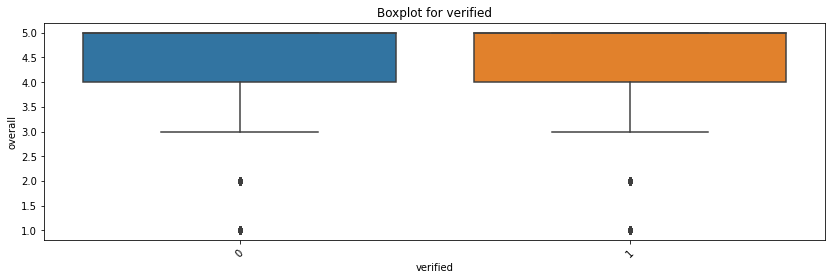

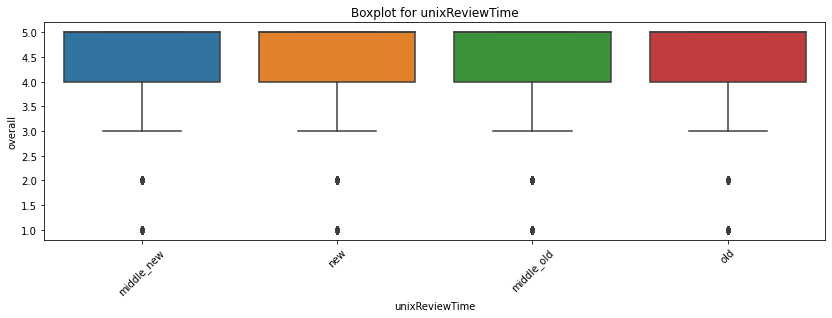

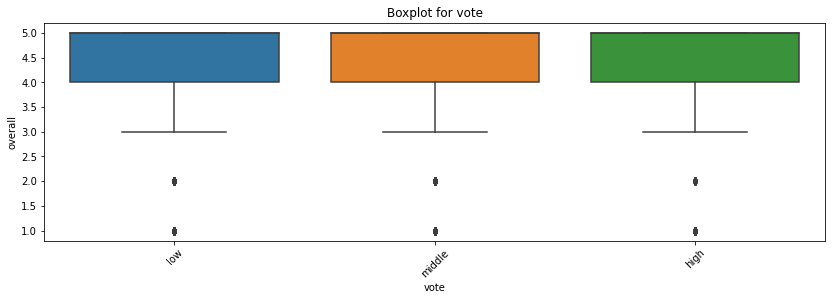

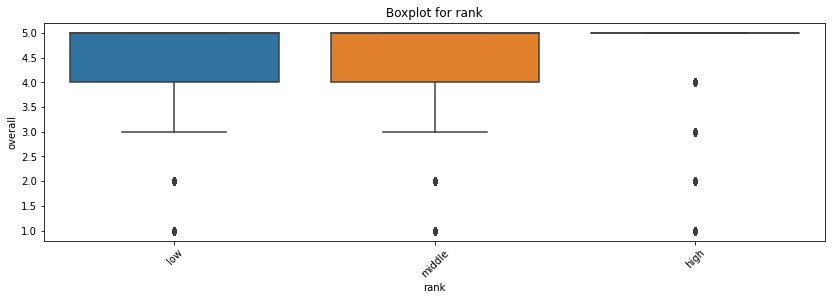

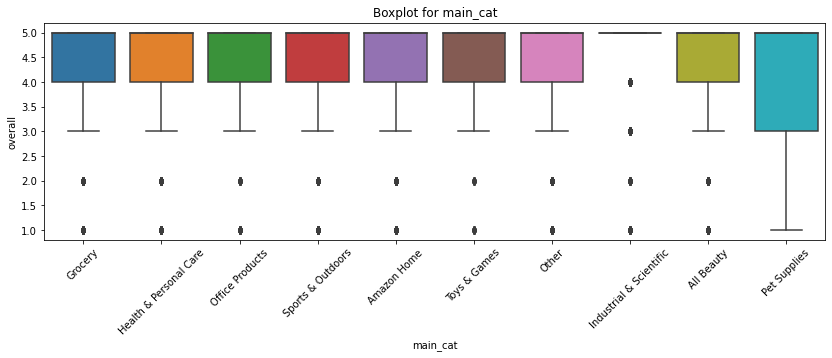

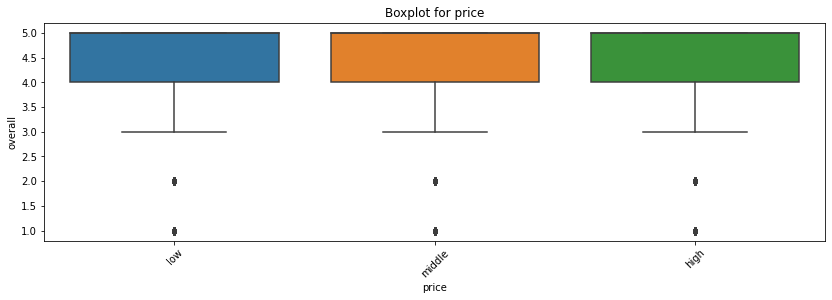

In [90]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_boxplot(col)

По графикам сильных различий не видно. Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий может помочь распознать статистика. Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок пользователей по различным параметрам неразличимы:

In [91]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'overall'], 
                        df.loc[df.loc[:, column] == comb[1], 'overall']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [92]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки unixReviewTime
Найдены статистически значимые различия для колонки vote
Найдены статистически значимые различия для колонки rank
Найдены статистически значимые различия для колонки main_cat
Найдены статистически значимые различия для колонки price


Как мы видим, распределение оценок серьезно различается по всем шести параметрам.

Удалим признак overall

In [93]:
df = df.drop('overall', axis=1)

## Итоги EDA

Кратко напишем, что мы сделали с каждым признаком:

* overall - оценки от 1 до 5. Нет в тестовой выборке, использовали как вспомогательный признак для анализа.
* verified - привели значения к 0 и 1
* reviewTime - удалили признак т.к. есть unixReviewTime
* asin - удалили признак т.к. не использовали, хотя наверное могли бы для also_buy, also_view, similar_item
* reviewerName - удалили т.к. есть userid
* reviewText - выдилили самые часто встречающиеся слова, сделали (все подготовили и закомментировали для скорости) dummy-переменные. Но все оказалось зря т.к. признака нет в тестовой выборке
* summary - удалили т.к. нет в тестовом датасете
* unixReviewTime - сделали 4 категории в зависимости от даты отзыва, сделали dummy-переменные
* vote - сделали 3 категории в зависимости от количества голосов, сделали dummy-переменные
* style - удалили т.к. больше половины пропусков
* image_x - удалили
* userid - оставили для модели
* itemid - оставили для модели
* rating - оставили для модели - целевая переменная
* category - выдилили самые часто встречающиеся категории, сделали (все подготовили и закомментировали для скорости) dummy-переменные
* description - выдилили самые часто встречающиеся слова, сделали (все подготовили и закомментировали для скорости) dummy-переменные
* title - удалили т.к. сильно похож на description
* brand - выдилили самых часто встречающихся производителей, сделали (все подготовили и закомментировали для скорости) dummy-переменные
* rank - сделали 3 категории в зависимости от ранга, сделали dummy-переменные
* also_view - удалили, но наверное можно было бы использовать
* main_cat - сделали dummy-переменные
* price - сделали 3 категории в зависимости от цены, сделали dummy-переменные
* also_buy - удалили, но наверное можно было бы использовать
* image_y - удалили
* date - удалили
* feature - удалили
* details - удалили
* similar_item - удалили, но наверное можно было бы использовать. Много пропусков.
* tech1 - удалили
* fit - удалили

В итоге получили большое количество признаков, которые можем использовать в нашей модели.

## Предсказания без использования фичей

Разделим тренировочный датасет на тренировочную и тестовую выборки

In [ ]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

Чтобы работать с моделями в библиотеке LightFm, нам нужно создать разреженные матрицы. Мы будем хранить данные в формате COO (координатный формат представления данных). Вместо хранения всех значений, которые включают нулевые значения, мы будем хранить только ненулевые значения. В COO данные представлены в виде (строка, столбец, значение).

In [ ]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'],)))

Обучим модель

In [ ]:
LR = 0.089
NUM_THREADS = 12 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

model = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model = model.fit(
    ratings_coo,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

Получим предсказания

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

Посчитаем метрику roc_auc_score

In [ ]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

В качестве эксперимента создадим ещё одну модель, которую обучим на всем тренировочном датасете

In [ ]:
# Создадим разреженную матрицу
ratings_coo2 = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'],)))

# Обучим модель
model2 = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model2 = model.fit(
    ratings_coo2,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

## Предсказание на тестовом датасете

Получим предсказания на тестовом датасете

In [ ]:
preds = model.predict(test.userid.values,
                      test.itemid.values)
preds2 = model2.predict(test.userid.values,
                      test.itemid.values)

Нормализуем предсказания

In [ ]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds2 = (preds2 - preds2.min())/(preds2 - preds2.min()).max()

## Submission

In [ ]:
submission['rating']= normalized_preds
submission.to_csv('submission.csv', index=False)

## Итоги работы

В результате мы провели подробный анализ данных и познакомились с основными принципами работы рекомендательных систем. Генерация dummy-переменных(в основном список наиболее часто встречающихся значений в текстовых колонках) - не принес заметных улучшений модели, при этом потреблял много ресурсов и времени при работе ноутбука. В итоге для простоты, решила не включать в итоговую версию. Также нам удалось улучшить baseline и получить значение rocauc выше 0.76.